In [107]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('Data\\ts_dataset_firenze.csv', index_col ='index', parse_dates=True)
df.index.freq='MS'

In [108]:
df['arrivi_tot'] = df['arrivi_tot']/df['popol_fin']*1000000
df['arrivi_ita'] = df['arrivi_ita']/df['popol_fin']*1000000
df['arrivi_str'] = df['arrivi_str']/df['popol_fin']*1000000

In [109]:
df = df.loc[:'2019']
df.tail()

,prezzi_vendita,reddito,arrivi_tot,arrivi_ita,arrivi_str,anagr_altri_com_canc,anagr_altri_com_iscr,canc_anagr,canc_anagr_altrimot,canc_anagr_est,...,ADD_HI,UL_JKL,ADD_JKL,UL_MN,ADD_MN,UL_OPQ,ADD_OPQ,UL_RSTU,ADD_RSTU,reddito_procapite_mens
index,,,,,,,,,,,,,,,,,,,,,
2019-08-01,3986.0,6.791836e+09,3.098830e+06,469932.606180,2.628897e+06,632.0,601.0,1435.0,403.0,46.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18192.677506
2019-09-01,4006.0,6.791836e+09,3.101497e+06,470337.017804,2.631160e+06,738.0,690.0,1783.0,660.0,48.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18208.333645
2019-10-01,4035.0,6.791836e+09,2.450021e+06,824341.697375,1.625679e+06,800.0,823.0,1714.0,514.0,50.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18228.859053
2019-11-01,4050.0,6.791836e+09,2.450791e+06,824600.638978,1.626190e+06,689.0,762.0,1646.0,550.0,41.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18234.585089
2019-12-01,4040.0,6.791836e+09,2.452694e+06,825240.944594,1.627453e+06,666.0,626.0,1349.0,315.0,42.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18248.744315


In [110]:
# Change the dtype of selected columns
cols = ['arrivi_tot', 'arrivi_ita', 'arrivi_str',
       'anagr_altri_com_canc', 'anagr_altri_com_iscr', 'canc_anagr',
       'canc_anagr_altrimot', 'canc_anagr_est', 'iscr_anagr',
       'iscr_anagr_altrimot', 'iscr_anagr_est', 'morti', 'nati_vivi',
        'saldo_altrimot', 'saldo_migr', 'saldo_migr_e_altrimot',
       'saldo_migr_est', 'saldo_migr_int', 'saldo_naturale',
       'saldotot_incr_decr', 'UL_BDE','UL_C','UL_F','UL_G','UL_HI','UL_JKL','UL_MN','UL_OPQ','UL_RSTU']
for col in cols:
    df[col] = df[col].astype(int)
#df.head()

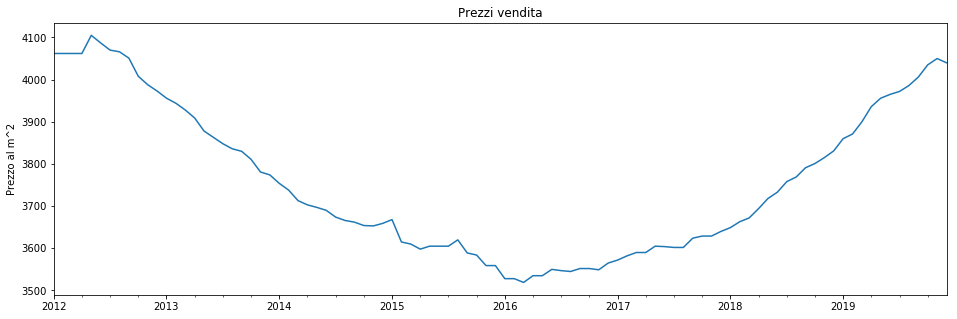

In [111]:
title='Prezzi vendita'
ylabel='Prezzo al m^2'
xlabel='' # we don't really need a label here

ax = df['prezzi_vendita'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [112]:
#NOT USED
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

NameError: name 'df1' is not defined

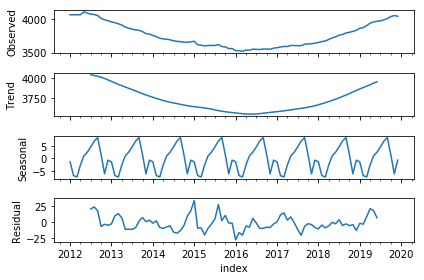

In [113]:
result = seasonal_decompose(df['prezzi_vendita'])
result.plot();

## Test for stationarity

In [114]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [115]:
adf_test(df['prezzi_vendita'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.615921
p-value                  0.089751
# lags used              7.000000
# observations          88.000000
critical value (1%)     -3.506944
critical value (5%)     -2.894990
critical value (10%)    -2.584615
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [116]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['prezzi_vendita'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -377.187
Date:                Fri, 15 Jan 2021   AIC                            760.374
Time:                        22:45:27   BIC                            768.004
Sample:                             0   HQIC                           763.456
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2230      0.282      0.791      0.429      -0.329       0.775
ma.L1         -0.8432      0.069    -12.179      0.000      -0.979      -0.708
sigma2       176.5540     21.312      8.284      0.000     134.784     218.324
===================================================================================
Ljung-Box (Q):                       26.70   Jarque-Bera (JB):                30.18
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.78
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
# Set four weeks for testing
train = df.iloc[:86]
test = df.iloc[86:]

## Now add the exog variable

In [118]:
df.columns

Index(['prezzi_vendita', 'reddito', 'arrivi_tot', 'arrivi_ita', 'arrivi_str',
       'anagr_altri_com_canc', 'anagr_altri_com_iscr', 'canc_anagr',
       'canc_anagr_altrimot', 'canc_anagr_est', 'iscr_anagr',
       'iscr_anagr_altrimot', 'iscr_anagr_est', 'morti', 'nati_vivi',
       'popol_fin', 'saldo_altrimot', 'saldo_migr', 'saldo_migr_e_altrimot',
       'saldo_migr_est', 'saldo_migr_int', 'saldo_naturale',
       'saldotot_incr_decr', 'pop_density', 'reddito_procapite_ann', 'UL_BDE',
       'ADD_BDE', 'UL_C', 'ADD_C', 'UL_F', 'ADD_F', 'UL_G', 'ADD_G', 'UL_HI',
       'ADD_HI', 'UL_JKL', 'ADD_JKL', 'UL_MN', 'ADD_MN', 'UL_OPQ', 'ADD_OPQ',
       'UL_RSTU', 'ADD_RSTU', 'reddito_procapite_mens'],
      dtype='object')

In [119]:
df.corr()['prezzi_vendita']

prezzi_vendita            1.000000
reddito                  -0.164205
arrivi_tot                0.048651
arrivi_ita                0.032602
arrivi_str                0.032682
anagr_altri_com_canc      0.311118
anagr_altri_com_iscr      0.296357
canc_anagr                0.100935
canc_anagr_altrimot       0.070018
canc_anagr_est           -0.660172
iscr_anagr                0.132724
iscr_anagr_altrimot       0.049741
iscr_anagr_est            0.314578
morti                    -0.096581
nati_vivi                -0.002037
popol_fin                -0.887691
saldo_altrimot            0.032596
saldo_migr                0.265918
saldo_migr_e_altrimot     0.133329
saldo_migr_est            0.445901
saldo_migr_int            0.132669
saldo_naturale            0.076603
saldotot_incr_decr        0.138207
pop_density              -0.887691
reddito_procapite_ann     0.845201
UL_BDE                   -0.298544
ADD_BDE                  -0.026976
UL_C                      0.240620
ADD_C               

In [164]:
predictors = [ 'arrivi_tot', 'arrivi_ita', 'arrivi_str','anagr_altri_com_canc', 'anagr_altri_com_iscr',
              'canc_anagr_est', 'iscr_anagr_est', 'saldo_migr_est', 'pop_density', 'reddito_procapite_ann',
              'UL_BDE', 'UL_C',  'UL_F', 'UL_G',  'UL_HI', 'UL_JKL',  'UL_MN',  'UL_OPQ', 'UL_RSTU']

In [165]:
model = SARIMAX(train['prezzi_vendita'],exog=train[predictors],order=(1,2,1),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         prezzi_vendita   No. Observations:                   86
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -331.777
Date:                Fri, 15 Jan 2021   AIC                            707.553
Time:                        23:09:29   BIC                            761.031
Sample:                    01-01-2012   HQIC                           729.051
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
arrivi_tot               -4.4689      1.756     -2.545      0.011      -7.910      -1.027
arrivi_ita                4.4688      1.756      2.545      0.011       1.027       7.910
arrivi_str                4.4689      1.756      2.545      0.011       1.027       7.910
anagr_altri_com_canc     -0.0137      0.008     -1.670      0.095      -0.030       0.002
anagr_altri_com_iscr      0.0106      0.007      1.448      0.148      -0.004       0.025
canc_anagr_est           -0.0117      0.051     -0.228      0.820      -0.112       0.089
iscr_anagr_est           -0.0111      0.027     -0.408      0.683      -0.064       0.042
saldo_migr_est            0.0006      0.026      0.022      0.982      -0.050       0.052
pop_density               0.5635      0.742      0.760      0.447      -0.890       2.017
reddito_procapite_ann     0.1305      1.915      0.068      0.946      -3.622       3.883
UL_BDE                    0.2025      3.953      0.051      0.959      -7.545       7.950
UL_C                     -0.4470      0.459     -0.975      0.330      -1.346       0.452
UL_F                     -0.6829     12.255     -0.056      0.956     -24.702      23.337
UL_G                      0.3042      4.534      0.067      0.947      -8.582       9.190
UL_HI                    -0.8094     14.579     -0.056      0.956     -29.384      27.766
UL_JKL                    0.3666      5.264      0.070      0.944      -9.950      10.683
UL_MN                    -0.0101      0.137     -0.073      0.942      -0.279       0.259
UL_OPQ                    0.3511     10.112      0.035      0.972     -19.467      20.170
UL_RSTU                  -0.1751      2.281     -0.077      0.939      -4.645       4.295
ar.L1                     0.1670      0.164      1.018      0.309      -0.155       0.488
ma.L1                    -0.7243      0.151     -4.812      0.000      -1.019      -0.429
sigma2                  137.7992     16.653      8.275      0.000     105.160     170.439
===================================================================================
Ljung-Box (Q):                       38.53   Jarque-Bera (JB):                15.75
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.53
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.12e+20. Standard errors may be unstable.
"""

In [160]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[predictors]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('ARIMAX(0,2,1) Predictions')

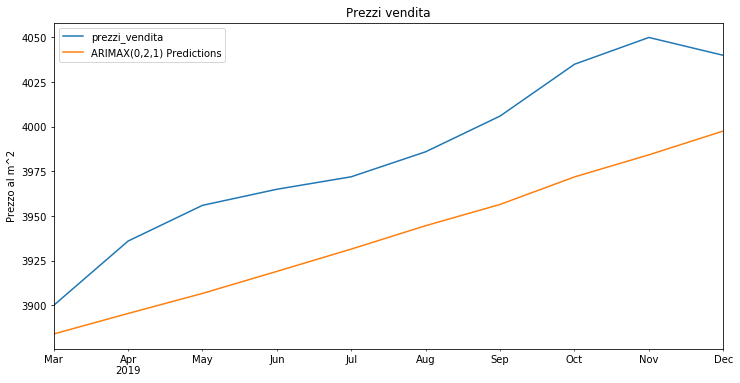

In [161]:
# Plot predictions against known values
title='Prezzi vendita'
ylabel='Prezzo al m^2'
xlabel=''

ax = test['prezzi_vendita'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [162]:
from statsmodels.tools.eval_measures import rmse

error2x = rmse(test['prezzi_vendita'], predictions)

# Print new ARIMAX values
print(f'ARIMAX(0,2,1) RMSE Error: {error2x:11.10}')

ARIMAX(0,2,1) RMSE Error: 47.26849057


In [163]:
test['prezzi_vendita'].std()

48.56427585055592

### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days into the future, and use the additional holiday data

In [78]:
model = SARIMAX(df['prezzi_vendita'],exog=df['pop_density'],order=(0,2,1),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['pop_density']]
fcast = results.predict(len(df),len(df)+10,exog=exog_forecast).rename('SARIMAX(0,2,1) Forecast')

ValueError: Provided exogenous values are not of the appropriate shape. Required (11, 1), got (0, 1).

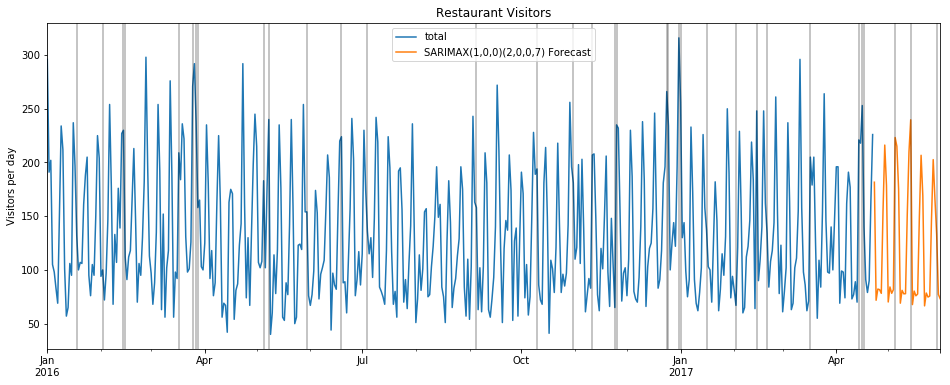

In [24]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);